# Detecção de bordas e filtragem
- Detecção de bordas é uma operação importante em processamento de imagens que é alcançada através de filtragem da imagem
- Filtragem por sua vez depende de um conceito fundamental chamado de **convolução 2D**
- Muitas das funções da biblioteca utilizam esses conceitos no seu codigo fonte

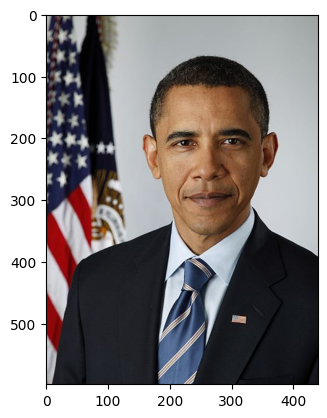

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

obama = cv2.cvtColor(cv2.imread("assets/obama.jpg"), cv2.COLOR_BGR2RGB)
obama_gray = cv2.cvtColor(obama, cv2.COLOR_RGB2GRAY)
plt.imshow(obama)

## Convolução
- O conceito de [convolução](https://pt.wikipedia.org/wiki/Convolu%C3%A7%C3%A3o) vem do processamento de sinais
- É um operador linear de duas funções que resulta em uma outra função
- Vamos supor que temos duas funções $f$ e $g$, a convolução discreta $f \ast g$ entre elas é definida como:

$$
(f \ast g)(k) = h(k) = \sum_{j=0}^{k} f(j)g(k-j)
$$

- Esse conceito é levado para imagens, mas com o nome de **convolução 2D**:

$$
H[i,j] = \sum_{u=-k}^{k} \sum_{v=-k}^{k} g[u,v]F[i+u,j+v]
$$

- Em processamento de imagens, $F$ é a imagens que desejamos filtrar e $G$ é um kernel que precisa ser definido e $H$ a imagem resultante
- É bem mais fácil entender visualmente
    - [Exemplo visual 1](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)
    - [Exemplo visual 2](https://cs231n.github.io/convolutional-networks/)

## Fazendo o primeiro filtro - Blurring
- Vamos aplicar um blur na imagem usando convolução    
- Blur nada mais é do que fazer a média dos pixels dentro de uma vizinhança
    - [Aqui](https://pyimagesearch.com/2021/04/28/opencv-smoothing-and-blurring/) você encontra um tutorial completo sobre o tema
- Possui diversas aplicações, entre elas:
    - Tirar ruido de uma imagem
    - Preparar a imagem para uma filtragem
- Também conhecido como um **filto passa baixa**
    - No contexto de de imagens, a frequência é relacionada a taxa de mudança dos valores pixels 
    - Se muda abruptamente, isso significa uma frequência alta
        - É fácil perceber que em uma borda isso aconteceria
        - Portanto, esse tipo de filtro aplica uma suavização nas bordas
        
### Criando e aplicando o filtro
- Para realizar a filtragem, precisamos definir um kernel
- O kernel para blurring nada mas é do que algo que faça a média de uma vizinhança
- Vamos começar usando o seguinte kernel:
$$G = \frac{1}{9}
\begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}
$$

- A divisão por 9 é para fazer com que a soma seja 1
    - Isso é chamado de normalização (para simular um filtro gaussiano)
    - Se não for feito, afeta o brilho da imagem
- Agora, vamos aplicar esse filtro a uma imagem usando a função `filter2D()` que é basicamente a aplicação de uma convolução

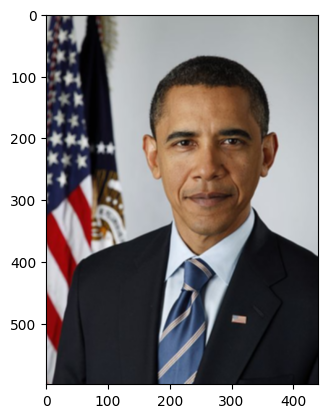

In [46]:
kernel = np.ones([3,3], dtype=np.float32)
kernel = kernel / kernel.sum()
obama_blur = cv2.filter2D(src=obama, # imagem a ser filtrada
                          ddepth=-1, # profundidade da imagem filtrada. -1 mantem a mesma da src
                          kernel=kernel # kernel para realizar a filtragem
                         )
plt.imshow(obama_blur)

- Observe que aumentar o tamanho do kernel resulta em maior blur
    - Porque?
- [Excelente exemplo visual de um blur](https://www.youtube.com/watch?v=8rrHTtUzyZA)


- Como essa é uma operação comum e importante a biblioteca possui uma função específica pra ela, a `blur()`

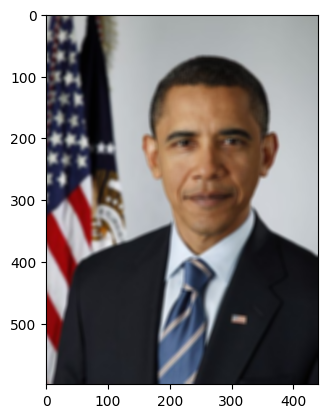

In [47]:
obama_blur = cv2.blur(obama, (7,7))
plt.imshow(obama_blur)

- Outras opções de blur:
    - `GaussianBlur()`: utiliza uma distribuição normal para fazer uma espécia de média ponderada
    - `medianBlur()`: utiliza a mediana (bem eficiente contra ruidos do estilo salt and pepper)
    - `bilateralBlur()`: utiliza duas Gaussianas, uma apenas par aconsiderar os vizinhos espaciais e outra para considerar os vizinos com intensidades semelhantes. É muito utilizada para preprocessar a imagem antes de detectar borda, uma vez que é capaz de manter boa parte dessas caraceristicas na imagem

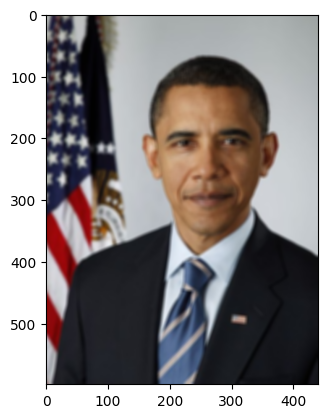

In [48]:
obama_blur = cv2.GaussianBlur(obama, (7,7), cv2.BORDER_DEFAULT)
plt.imshow(obama_blur)

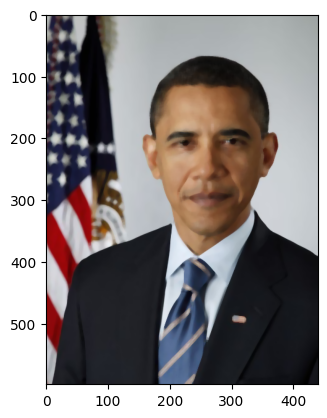

In [49]:
obama_blur = cv2.medianBlur(obama, 7)
plt.imshow(obama_blur)

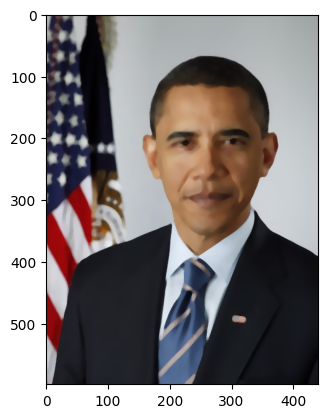

In [50]:
obama_blur = cv2.bilateralFilter(obama_blur, # imagem a ser aplicado o filtro
                                 11,  # diametro da vizinhança (quanto maior, mais pixels vao ser considerados)
                                 21, # desvio padrao da cor que vai ser considerada (quanto maior, mais a gente se aproxima da gaussiana padrão)
                                 7 # desvio padrao espacial (quanto maior, mais pixels vao influenciar)
                                )
plt.imshow(obama_blur)

- De maneira geral, filtrar uma imagem significa definir um kernel e aplicar a convolução
- Isso é usado largamente para diversas operações

## Sharpening
- Operação que da destaque as bordas de uma imagem
- Obviamente, é usada como um preprocessamento para melhorar essa detecção
- A ideia é a mesma do blur, define-se um kernel e depois aplica a filtragem
- Existem diversos kernels para aplicar tal operação, vamos começar pelo seguinte:

$$
G = 
\begin{bmatrix}
-1 & -1 & -1\\
-1 & 9 & -1\\
-1 & -1 & -1\\
\end{bmatrix}
$$

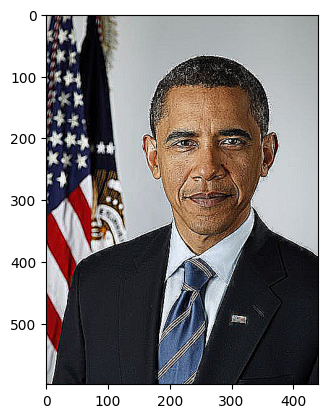

In [51]:
kernel = np.ones([3,3], dtype=np.float32) * -1
kernel[1,1] = 9
obama_sharp = cv2.filter2D(src=obama, ddepth=-1, kernel=kernel)
plt.imshow(obama_sharp)

- Se quisermos aplicar um sharp execessivo, poriamos usar:

$$
G = 
\begin{bmatrix}
1 & 1 & 1\\
1 & -7 & 1\\
1 & 1 & 1\\
\end{bmatrix}
$$

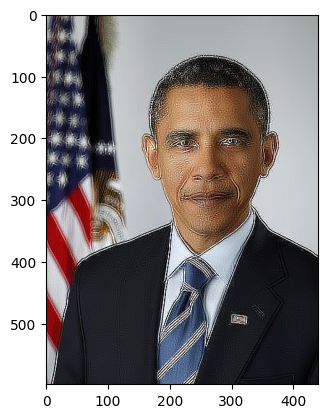

In [52]:
kernel = np.ones([3,3], dtype=np.float32)
kernel[1,1] = -7
obama_sharp = cv2.filter2D(src=obama, ddepth=-1, kernel=kernel)
plt.imshow(obama_sharp)

- Mas perceba que a imagem fica muito deformanda
- Uma opção é fazer uma espécie de sharp + gaussian

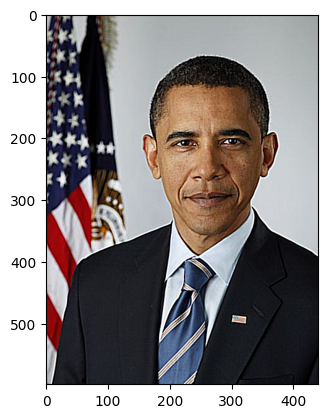

In [53]:
kernel = np.array([
                    [-1,-1,-1,-1,-1],
                    [-1, 2, 2, 2,-1],
                    [-1, 2, 8, 2,-1],
                    [-1, 2, 2, 2,-1],
                    [-1,-1,-1,-1,-1]
                  ])
kernel = kernel / kernel.sum()
obama_sharp = cv2.filter2D(src=obama, ddepth=-1, kernel=kernel)
plt.imshow(obama_sharp)

## Embossing
- Operação que troca o pixel original por algo como uma sobra ou um destaque
- Também é um técnica comum de preprocessamento de imagem
- Exemplo de kernel:

$$
G = 
\begin{bmatrix}
0 & -1 & -1\\
1 & 0 & -1\\
1 & 1 & 0
\end{bmatrix}
$$

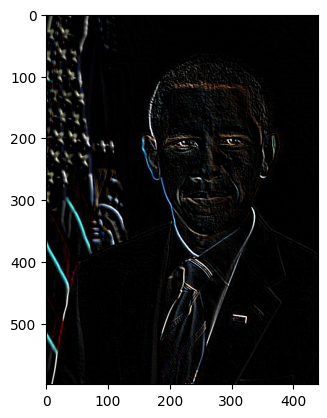

In [54]:
kernel = np.array([
                    [0, -1, -1],
                    [1, 0,  -1],
                    [1, 1,   0]                    
                  ])
obama_emb = cv2.filter2D(src=obama, ddepth=-1, kernel=kernel)
plt.imshow(obama_emb)

- Podemos aplicar a operação para uma imagem em tons de cinza

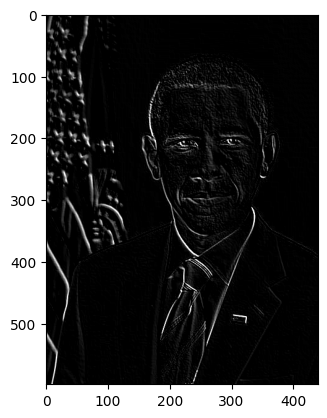

In [55]:
obama_emb = cv2.filter2D(src=obama_gray, ddepth=-1, kernel=kernel)
plt.imshow(obama_emb, cmap="gray")

- Também podemos alterar o filtro

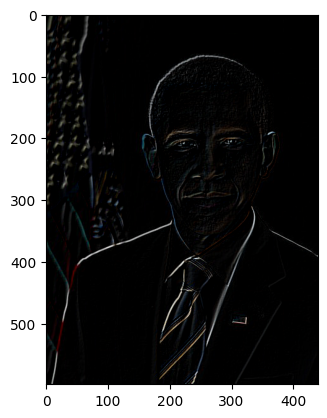

In [56]:
kernel = np.array([
                    [1, 0,  0],
                    [0, 0,  0],
                    [0, 0, -1]                    
                  ])
obama_emb = cv2.filter2D(src=obama, ddepth=-1, kernel=kernel)
plt.imshow(obama_emb)

## Detecção de bordas
- Basicamente é o processo de encontrar as bordas de uma imagem e devolver uma máscara, que nada mais é do que uma imagem binária (preto e branco)
- Como já discutido, é uma operação que envolve operações de filtragem de altas frequências
    - Ou seja, detectar onde tem mudanças abruptas de cores
    - São utilizados kernels que filtragem passa alta
- Uma outra forma de interpretar a localização de uma borda é através de um derivada
    - A borda na mais é do que uma mudança abrupta de pixels
    
    
### Sobel

- Um filtro famoso é o `sobel`, que é um operador de diferenciaçã discreto
    - É uma aproximação da derivada de intenside dos pixels de uma imagem
    - Combina suvização gaussiana com diferenciação
- Existem dois kernels:


$$
S_y = 
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 
\end{bmatrix}
$$

$$
S_x = 
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 
\end{bmatrix}
$$

- $S_x$ detecta bordas horizontais, enquanto $S_y$ as verticais
- Em um dado ponto de uma imagem, podemos calcular gradiente da seguinte forma: $S = \sqrt{S_x^2 + S_y^2}$
- Para exemplificar, vamos carregar uma outra imagem:

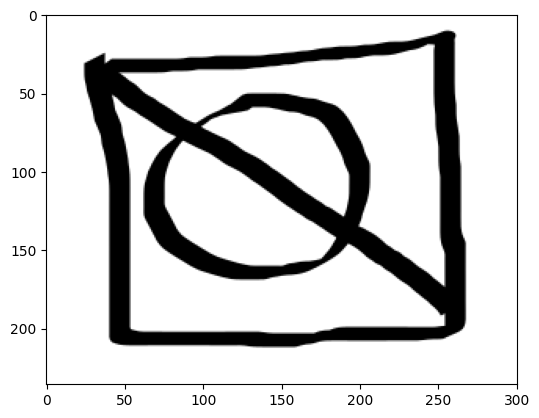

In [57]:
formas = cv2.cvtColor(cv2.imread("assets/formas.png"), cv2.COLOR_BGR2GRAY)
plt.imshow(formas, cmap="gray")

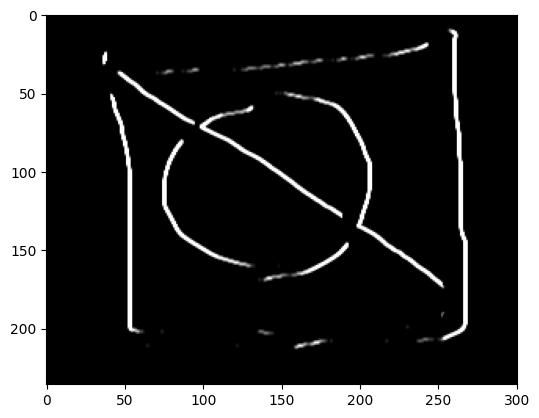

In [58]:
s_x = np.array([ [-1, 0, 1],
                 [-2, 0,  2],
                 [-1, 0, 1]                    
              ])
formas_sob_x = cv2.filter2D(src=formas, ddepth=-1, kernel=s_x)
plt.imshow(formas_sob_x, cmap="gray")

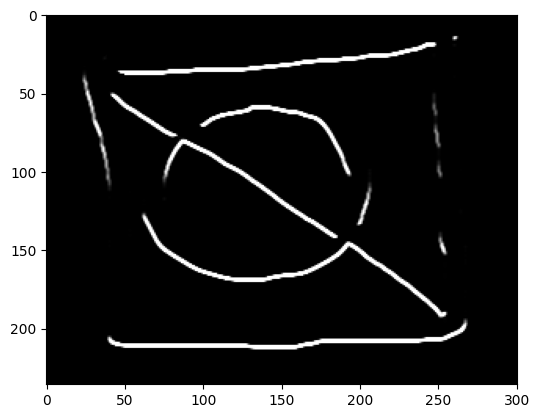

In [59]:
s_y = np.array([ [-1, -2, -1],
                 [0, 0,  0],
                 [1, 2, 1]                    
              ])
formas_sob_y = cv2.filter2D(src=formas, ddepth=-1, kernel=s_y)
plt.imshow(formas_sob_y, cmap="gray")

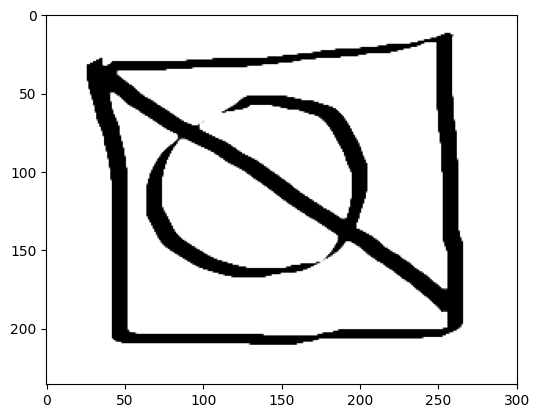

In [60]:
s = np.sqrt(s_x**2 + s_y**2)
formas_sob = cv2.filter2D(src=formas, ddepth=-1, kernel=s)
plt.imshow(formas_sob, cmap="gray")

- A biblioteca oferece uma função para aplicarmos `sobel`

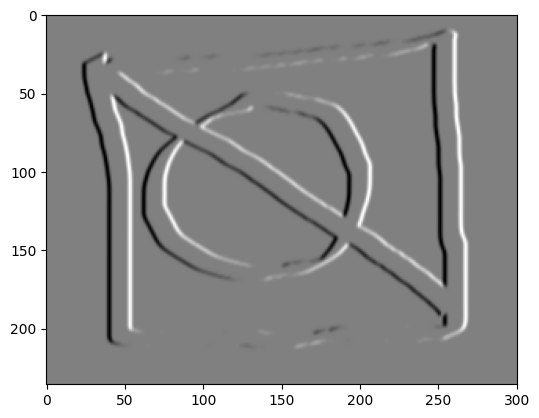

In [61]:
formas_sob = cv2.Sobel(formas, # imagem para aplicar o filtro
                       cv2.CV_16S, # o depth fa imagem de saida
                       1, # ordem da derivada na direção de X
                       0, # ordem da derivada na direção de Y
                       ksize=5 # tamanho do kernel
                      )
plt.imshow(formas_sob, cmap="gray")

- Obtendo uma máscara preto e branco usando a função `threshold()`

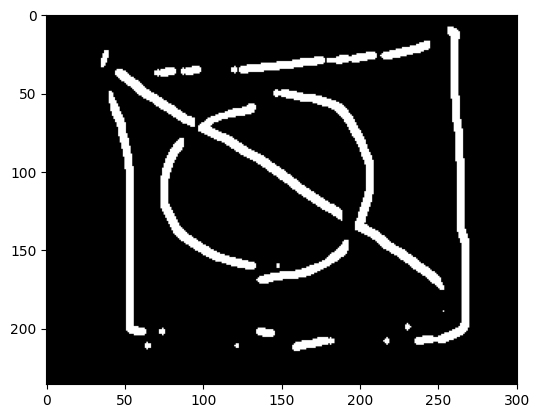

In [62]:
thresh = 50
t, forma_bw = cv2.threshold(formas_sob, thresh, 255, cv2.THRESH_BINARY)
plt.imshow(forma_bw, cmap="gray")

### Laplacian
- Uma outra opção para detectar bordas é o filtro laplaciano
- A vantagem é que ele calcula derivadas de segunda ordem em ambas as direções
- A biblioteca fornece a função `Laplacian()`
    - Que internamente chama a `Sobel()`

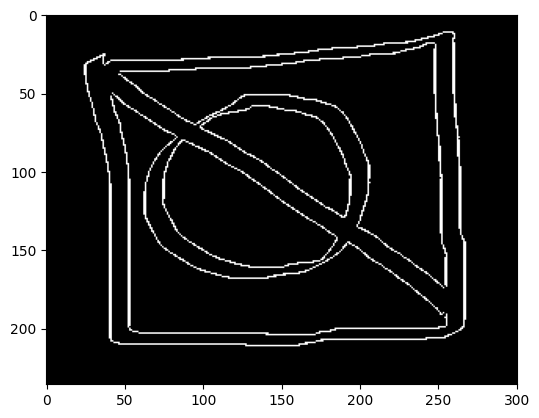

In [63]:
formas_lap = cv2.Laplacian(formas, cv2.CV_8U, 5)
thresh = 50
t, forma_bw = cv2.threshold(formas_lap, thresh, 255, cv2.THRESH_BINARY)
plt.imshow(forma_bw, cmap="gray")

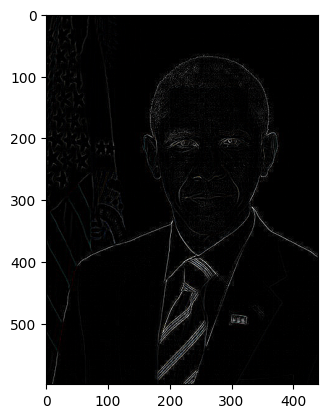

In [64]:
obama_lap = cv2.Laplacian(obama, cv2.CV_8U, 5)
plt.imshow(obama_lap, cmap="gray")

### Canny
- Uma outra opção de detector de borda é o `Canny`
- Esse algoritmo utiliza dois thresholds o lower e o upper
- A ideia do algoritmo é a seguinte:
    1. Aplica um filtro Gaussiano para diminuir ruido
    2. Calculas de derivadas em ambas as direções
    3. Se o pixel do gradiente é maior do que upper, então ele é aceito como uma borda
    4. Se o pixel do gradiente é menor do que lower, então ele é rejeitado
    5. Para todos os pixels entre os threshods, ele é aceito se estiver conectado com pixels aceitos em 3

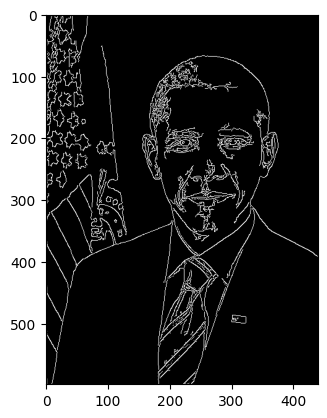

In [65]:
obama_can = cv2.Canny(obama, 50, 240)
plt.imshow(obama_can, cmap="gray")

## Contornos
- Um contorno nada mais é do que pontos contínuos conectados que possuem mesma cor e intensidade 
- Muito útil para detectar formas e objetos
- Funciona muito melhor com imagens binarias
- Na biblioteca usamos a função `findContours()`
    - Retorna uma lista de contornos e [hierarquias](https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html#:~:text=This%20way%2C%20contours%20in%20an,relationship%20is%20called%20the%20Hierarchy.)

In [66]:
contours, hier = cv2.findContours(obama_can, # imagens que vai buscar os contornos
                                  cv2.RETR_EXTERNAL, # método de contorno (existem vários)
                                  cv2.CHAIN_APPROX_NONE # uma maneira de reduzir a quantidade de contornos. Se for None, pega tudo
                                 )

- Podemos desenhar os contornos encontrados

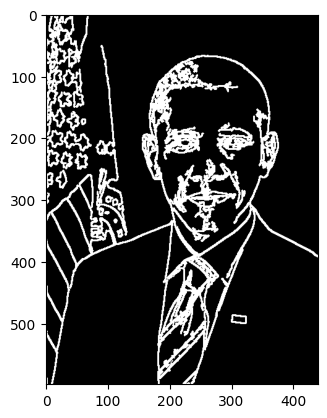

In [67]:
obama_cnt = cv2.drawContours(np.zeros_like(obama_can), # definindo a imagem onde vai ser desenhado
                             contours, # passando os contornos
                             -1, # índice do contorno que vai ser desenhado (-1 desenha tudo)
                             (255,255,255), # cor do contorno 
                             2 # grossura da linha
                            )
plt.imshow(obama_cnt, cmap="gray")

- Vamos usar a função `contourArea()` para calcular a área de uma contorno e tentar identificar contornos maiores na imagem

In [68]:
def find_contours_min(contours, a_min):
    for k, cnt in enumerate(contours):
        c_area = cv2.contourArea(cnt)
        if c_area > a_min:
            print(f"contours[{k}]: {c_area}")
            
find_contours_min(contours, 100)

contours[30]: 162.0
contours[37]: 244.5
contours[64]: 143.0
contours[65]: 111.5
contours[99]: 125.0
contours[110]: 279.0
contours[137]: 127.0
contours[155]: 158.0
contours[174]: 338.0
contours[191]: 129.0
contours[214]: 508.5
contours[233]: 269.0


#### Identificando contornos com retangulos
- Criar um rentangulo em volta de uma forma que identificamos
- Para isso vamos carregar uma nova figura

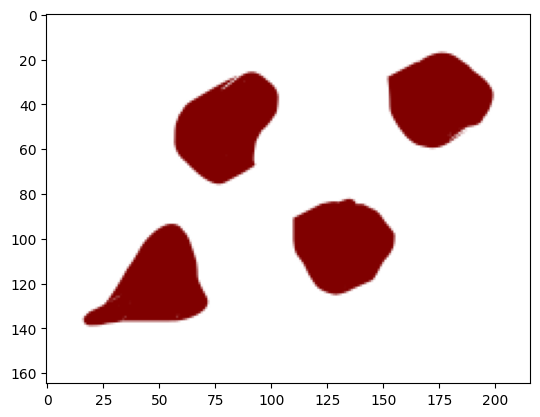

In [69]:
formas_2 = cv2.imread("assets/formas_2.png")
plt.imshow(formas_2, cmap="gray")

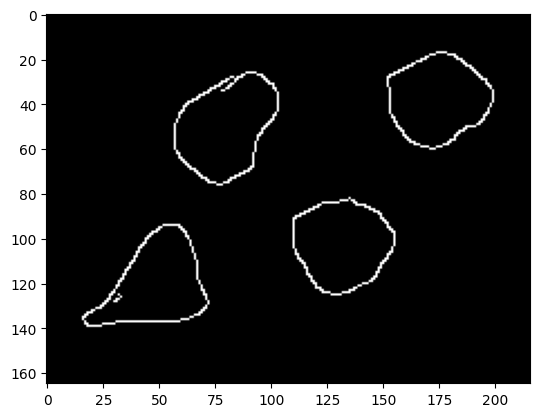

In [70]:
formas_2_can = cv2.Canny(formas_2, 50, 240)
plt.imshow(formas_2_can, cmap="gray")

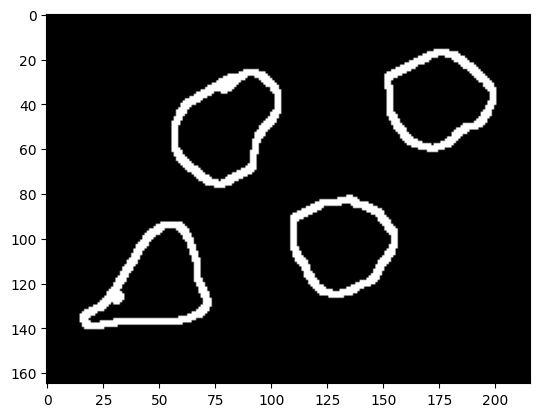

In [71]:
contours, hier = cv2.findContours(formas_2_can, # imagens que vai buscar os contornos
                                  cv2.RETR_TREE, # método de contorno (existem vários)
                                  cv2.CHAIN_APPROX_SIMPLE # uma maneira de reduzir a quantidade de contornos. Se for None, pega tudo
                                 )

forma_cnt = cv2.drawContours(np.zeros_like(formas_2_can), # definindo a imagem onde vai ser desenhado
                             contours, # passando os contornos
                             -1, # índice do contorno que vai ser desenhado (-1 desenha tudo)
                             (255,255,255), # cor do contorno 
                             2 # grossura da linha
                            )

plt.imshow(forma_cnt, cmap="gray")

- Dando uma olhada nos contornos

In [72]:
find_contours_min(contours, 100)

contours[0]: 1425.5
contours[1]: 1385.5
contours[3]: 1417.5
contours[4]: 1375.5
contours[5]: 1562.5
contours[6]: 1510.0
contours[7]: 1434.5
contours[8]: 1391.5


- Podemos obter o peŕimetro do contorno

In [73]:
peri = cv2.arcLength(contours[0], # o contorno
                     True # se True, indica que é uma forma fechada
                    )
peri

169.7817441225052

- Agora vamos aproximar a forma do contorno para uma outra forma com menos vertices (de acordo com a precisão especificada)
- É bem útil para demarcar uma imagem com um quadrado, por exemplo


To understand this, suppose you are trying to find a square in an image, but due to some problems in the image, you didn’t get a perfect square, but a “bad shape” (As shown in first image below). Now you can use this function to approximate the shape. In this, second argument is called epsilon, which is maximum distance from contour to approximated contour. It is an accuracy parameter. A wise selection of epsilon is needed to get the correct output.

In [74]:
approx_cnt = cv2.approxPolyDP(contours[0], # contorno
                              0.1*peri, # precisao da aproximação
                              True # se True, indica que é uma forma fechada
                             )
approx_cnt

array([[[ 59,  94]],

       [[ 18, 139]],

       [[ 71, 131]]], dtype=int32)

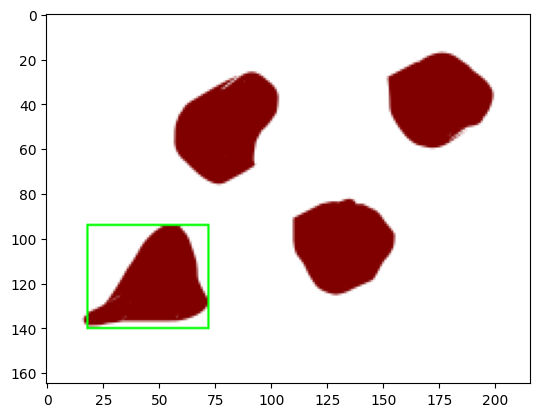

In [75]:
x, y, w, h = cv2.boundingRect(approx_cnt)
formas_final = cv2.rectangle(formas_2.copy(), (x,y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(formas_final)

___
# Exercício:
- Faça uma função que insira o retângulo em todas as formas da imagem anterior
___

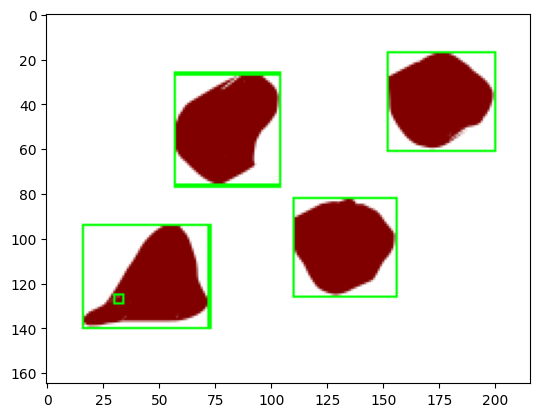

In [83]:
def draw_all_objects(img, contours):
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx_cnt = cv2.approxPolyDP(cnt, 0.01*peri, True)
        x, y, w, h = cv2.boundingRect(approx_cnt)
        img = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255, 0), 1)

    return img

formas_2 = cv2.imread("assets/formas_2.png")
formas_2_can = cv2.Canny(formas_2, 50, 240)
contours, hier = cv2.findContours(formas_2_can, # imagens que vai buscar os contornos
                                  cv2.RETR_TREE, # método de contorno (existem vários)
                                  cv2.CHAIN_APPROX_SIMPLE # uma maneira de reduzir a quantidade de contornos. Se for None, pega tudo
                                 )

img = draw_all_objects(formas_2, contours)
plt.imshow(img)